# Flatiron School Data Science Immersive 
# Module 1 Project 
## Multivariate Analysis: Home Prices in King County, WA

##### Author: Valentina C. Fontiveros

<img src="house_banner.png"/>

## Objectives

> To use data science tools to complete a multivariate analysis of factors influencing home prices in King County, WA.

> To demonstrate the skills gained after completing Module 1 of the Data Science Immersive.

## Background

> The dataset* used in this analysis records physical characteristics and prices of approximately twenty thousand housing units sold in King County, WA during 2014 and 2015.

> Seattle, a major tech hub in the world, is located in this county.

> As of 2010, it was the most densely-populated county in Washington.

> *Flatiron School has provided and modified the original dataset.


##### Population Density of Washington State counties.

<img src= "King_County.jpg" width=400 align='left' />

## Data Analysis | OSEMiN Framework 

> On this project, we will use the OSEM Data Science framework.

> OSEM stands for:
    > Obtain 
    > Scrub 
    > Explore 
    > Model 
    > Interpret

### Import Libraries

> The libraries used provide useful tools for data science workflows.

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 
from scipy.stats import kurtosis, skew
import folium
from folium import plugins
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline

### Obtain and Sort Data

> Set index to ID
> Ordered by price,zipcode,then ID

In [182]:
df = pd.read_csv('kc_house_data.csv') # dataset provided by Flatiron School
df.set_index('id', inplace=True)
df.sort_values(by =['price','zipcode','id'], inplace=True, ascending=True)
df.head() #preview data



,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
40000362,5/6/2014,78000.0,2,1.00,780,16344,1.0,0.0,0.0,1,5,780,0.0,1942,NaN,98168,47.4739,-122.280,1700,10387
8658300340,5/23/2014,80000.0,1,0.75,430,5050,1.0,NaN,0.0,2,4,430,0.0,1912,0.0,98014,47.6499,-121.909,1200,7500
3028200080,3/24/2015,81000.0,2,1.00,730,9975,1.0,NaN,0.0,1,5,730,0.0,1943,0.0,98168,47.4808,-122.315,860,9000
3883800011,11/5/2014,82000.0,3,1.00,860,10426,1.0,0.0,0.0,3,6,860,0.0,1954,0.0,98146,47.4987,-122.341,1140,11250
1623049041,5/8/2014,82500.0,2,1.00,520,22334,1.0,0.0,0.0,2,5,520,0.0,1951,0.0,98168,47.4799,-122.296,1572,10570


> There are a number of columns which were not 
visible on the preview display. Let's display all the column names.

In [183]:
print('There are ' + str(len(df.columns)) + ' columns in the dataframe.')
df.columns


There are 20 columns in the dataframe.


Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

> We see 20 columns of information, describing various attributes of houses in King County.

## Scrub Data 

### House Prices:  
 

#### Price - Distribution

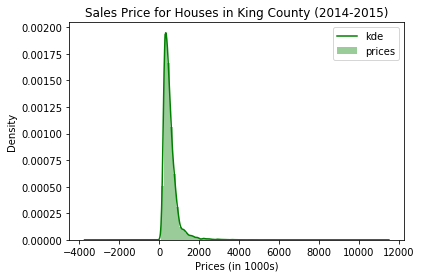

Skewness = 4.023085207745835
kurtosis = 34.53308449607733


In [184]:
# generate histogram for price containing all data
prices = df.price/1000
prices.hist(label = 'prices', bins=50,density=True,color='green',alpha=0.4)
prices.plot.kde(label='kde',color = 'green')
plt.title('Sales Price for Houses in King County (2014-2015)')
plt.xlabel('Prices (in 1000s)')
plt.legend()
plt.show()
print ('Skewness =', skew(df.price))
print ('kurtosis =', kurtosis(df.price))


Observations: high positive skew, extremely high + curtosis, long-tailed distribution.

#### Price - Summary Statistics

In [185]:
# Summary statitics
df.price.describe().apply(lambda x: format(x, 'f'))

count      21597.000000
mean      540296.573506
std       367368.140101
min        78000.000000
25%       322000.000000
50%       450000.000000
75%       645000.000000
max      7700000.000000
Name: price, dtype: object

Observations: ~ 20,000 samples, high standard deviation / variability

Text(0.5, 1.0, 'Distribution of House Prices (in 1000s)')

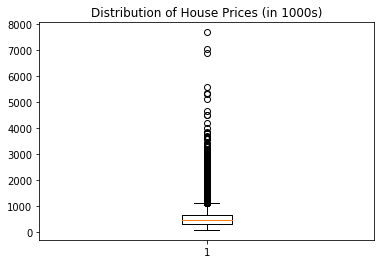

In [186]:
# Spot outliers
plt.boxplot(df.price/1000)
plt.title('Distribution of House Prices (in 1000s)')

Observations: numerous outliers

#### Price - Store in Dataframe after log normalizing

Skewness = 0.43097424174908705
kurtosis = 0.6906107356267639


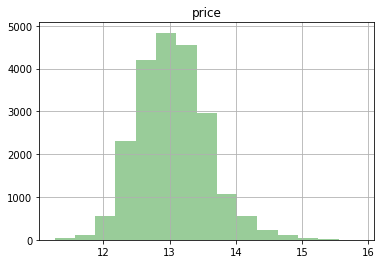

In [187]:
# Take the log of price and store in
price_df = pd.DataFrame(np.log(df.price))
price_df.hist(bins=15,color='green',alpha=0.4)
print ('Skewness =', skew(price_df.price))
print ('kurtosis =', kurtosis(price_df.price))

After log normalizing, the skewness and kurtosis improved.

#### Price - Data Type

In [188]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 1 columns):
price    21597 non-null float64
dtypes: float64(1)
memory usage: 337.5 KB


Observation: price is a float, which is appropriate due to the log transformation.

### Features - Store in Dataframe

In [189]:
# create a dataframe for features
features = df.columns.drop(['price'])
features_df = pd.DataFrame(df[features])
features_df.head(2)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
40000362,5/6/2014,2,1.00,780,16344,1.0,0.0,0.0,1,5,780,0.0,1942,NaN,98168,47.4739,-122.280,1700,10387
8658300340,5/23/2014,1,0.75,430,5050,1.0,NaN,0.0,2,4,430,0.0,1912,0.0,98014,47.6499,-121.909,1200,7500


###   Features: Descriptive Statistics

#### Data Types 

In [190]:
# obtain column info
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 19 columns):
date             21597 non-null object
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(7), int64(10), object(2)
memory usage: 3.3+ MB


Observations:

> There are numerous variables that should be tranformed to categories.

> There are geographical features that would be interesting to display on a map.

> Some variables could be transformed from float to int for efficiency.

### Transform Data Types

Scan features to determine best transformation

In [191]:
# This function scans features dataframe for unique values

# Even though this output is large, scanning all the data is important
# if we are not familiar with its peculiarities.

def unique(features_df):
    for column in features_df:
        print('Name: ' + column)
        print('-'*10)
        na = features_df[column].isna().sum()
        print('NaN values: ' + str(na))
        print('-'*10)
        unique = features_df[column].unique()

        print(unique)

        print('')

In [192]:
unique(features_df)

Name: date
----------
NaN values: 0
----------
['5/6/2014' '5/23/2014' '3/24/2015' '11/5/2014' '5/8/2014' '5/29/2014'
 '4/30/2015' '3/5/2015' '9/15/2014' '7/22/2014' '10/14/2014' '2/19/2015'
 '5/13/2014' '11/29/2014' '4/18/2015' '3/3/2015' '6/16/2014' '5/5/2015'
 '9/19/2014' '12/12/2014' '4/8/2015' '10/29/2014' '1/5/2015' '7/17/2014'
 '5/7/2014' '7/3/2014' '6/10/2014' '6/30/2014' '9/4/2014' '7/1/2014'
 '12/8/2014' '9/2/2014' '3/17/2015' '7/16/2014' '11/26/2014' '8/28/2014'
 '1/14/2015' '9/18/2014' '3/11/2015' '5/12/2014' '10/30/2014' '1/27/2015'
 '6/11/2014' '4/27/2015' '5/19/2014' '2/11/2015' '7/25/2014' '10/17/2014'
 '7/10/2014' '12/5/2014' '7/8/2014' '2/24/2015' '7/15/2014' '1/16/2015'
 '9/24/2014' '10/21/2014' '9/16/2014' '6/4/2014' '1/21/2015' '6/19/2014'
 '10/27/2014' '5/20/2014' '8/4/2014' '3/6/2015' '4/20/2015' '4/22/2015'
 '7/2/2014' '12/26/2014' '12/15/2014' '10/3/2014' '3/26/2015' '5/28/2014'
 '9/5/2014' '10/2/2014' '12/10/2014' '8/26/2014' '10/9/2014' '4/28/2015'
 '11/13/20

> We can see above than none of the categorical variables are identified as such.
> We need to transform the type for several of these variables.

There are problems with various variables.
Address those one variable at a time below 

#### 1. 'sqft_basement' feature

This feature contains unknown values marked with a "?"

In [193]:
# Let's explore how many ? entries are in sqft_basement.
value = '?'
count = 0
for row in features_df['sqft_basement']:
    if row == '?':
        count +=1
print('There are ' + str(count) + ' rows with question marks as unknown values.')
print('This represents ' + str(round(count/len(features_df)*100,2)) + ' percent of the data.')

There are 454 rows with question marks as unknown values.
This represents 2.1 percent of the data.


In [194]:
value = 0
count = 0
for row in features_df['sqft_basement']:
    if row == '0.0':
        count +=1
print('There are ' + str(count) + ' rows with 0 as unknown values.')
print('This represents ' + str(round(count/len(features_df)*100,2)) + ' percent of the data.')

There are 12826 rows with 0 as unknown values.
This represents 59.39 percent of the data.


> There are several ways to transform the unknown ? entries. We could drop these rows or replace them with the median (which is zero)

> Personally, I prefer replacing with the median to begin with, which would introduce a neglible amount of noise.

The median value for this basement area is: 0.0
The mean value for this basement area is: 291.851723974838


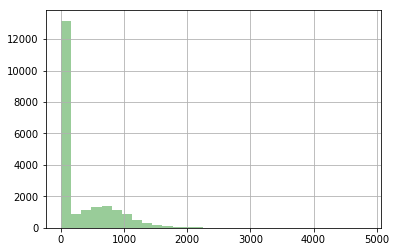

In [195]:
# Because we can't calculate the mean of the dataset with strings, let's create a dummy
# variable to replace the question mark with first.
value = '?'
dummy = 99999
############# . df.loc[:,"Score1"].median()

features_df.loc[:,'sqft_basement'].replace(value, dummy,inplace=True) 

# Now let's convert the type to int
features_df['sqft_basement'] = features_df['sqft_basement'].map(lambda x: float(x))
features_df['sqft_basement'] = features_df['sqft_basement'].map(lambda x: int(x))
features_df['sqft_basement'].unique()[0:15]

# Now let's replace 99999 with the median
features_df.loc[:,'sqft_basement'].replace(dummy,np.nan, inplace=True) 

# Let's plot a histogram 
features_df['sqft_basement'].hist(bins=30,color='green',alpha=0.4)
print('The median value for this basement area is: ' + str(features_df['sqft_basement'].median()))
print('The mean value for this basement area is: ' + str(features_df['sqft_basement'].mean()))


> Since the median for known basement values is zero, we will replace the unknown ? values
> with zero.


In [196]:
# Replace original '?' entries with zeros.
median_sqft = features_df['sqft_basement'].median()
features_df['sqft_basement']= features_df['sqft_basement'].replace(np.nan, median_sqft) 
features_df['sqft_basement'].unique()[0:10]
features_df.sqft_basement = features_df.sqft_basement.astype(int)
print('Done replacing "?" with zeros in sqft_basement')


Done replacing "?" with zeros in sqft_basement


#### 2. 'date' feature:

> Create a column for the year sold based on 'date'. Reformat to integer.
> We will assume that the exact day of the sale is not relevant to our analysis.

In [197]:
# compute two new features: yr_sold and month_sold
features_df['yr_sold'] = features_df['date'].map(lambda x: x.split('/',3))
features_df['month_sold'] = features_df['yr_sold'].map(lambda x: int(x[0]))
features_df['yr_sold'] = features_df['yr_sold'].map(lambda x: int(x[2]))

print('Years of reported sales:')
print(features_df['yr_sold'].unique())
print('Months of reported sales:')
print(features_df['month_sold'].unique())
#features_df.drop('date', axis=1, inplace=True)

Years of reported sales:
[2014 2015]
Months of reported sales:
[ 5  3 11  4  9  7 10  2  6 12  1  8]


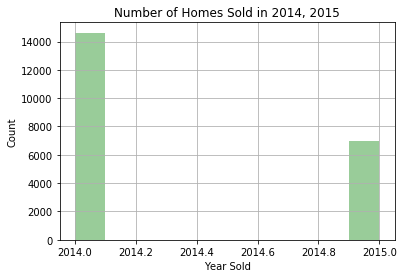

In [198]:
# Explore how many homes were sold in 2014 and 2015
features_df.yr_sold.hist(color='green',alpha=.4)
plt.xlabel('Year Sold')
plt.ylabel('Count')
plt.title('Number of Homes Sold in 2014, 2015')
plt.show()

> Observations: Sales decreased by nearly 50% in 2015.

Mean price in 2014: 538411.0
Mean price in 2015: 538071.0


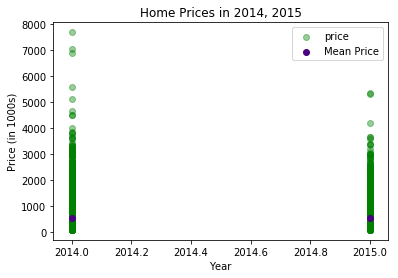

In [199]:
# Find out whether mean/median prices changed from one year to the next.
temp_price = pd.DataFrame(data=df.price)
temp_df = temp_price.join(features_df, how='left')
plt.scatter(temp_df.yr_sold,temp_df.price/1000,color='green',alpha=0.4)
plt.scatter(2014, temp_df.price[temp_df.yr_sold == 2014].mean()/1000, color='indigo',label='Mean Price') 
plt.scatter(2015, temp_df.price[temp_df.yr_sold == 2015].mean()/1000, color='indigo') 
print('Mean price in 2014: ' + str(round(temp_df.price[temp_df.yr_sold==2014].mean(),0)))
print('Mean price in 2015: ' + str(round(temp_df.price[temp_df.yr_sold==2015].mean(),0)))
plt.title('Home Prices in 2014, 2015')
plt.xlabel('Year')
plt.ylabel('Price (in 1000s)')
plt.legend()
plt.show()

> No significant differences are apparent in value of home prices between 2014 and 2015. 
> This probably suggests that this data has been edited for the purposes of this project.
> There is no clear discrimination of price year after year, even though 2014 contains most of the outliers.

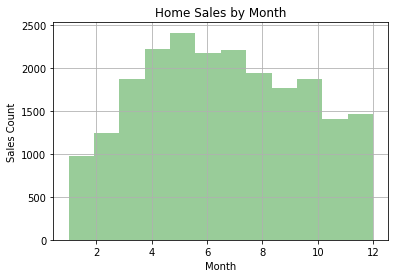

In [200]:
features_df.month_sold.hist(color='green',alpha=.4,bins=12)
plt.title('Home Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales Count')
plt.show()

> Observations: Sales pick up in the Spring, peak in May and slow down in late Fall and Winter.

521258.85814185813
505003.54972592014
540361.4801670146
557871.8432408631
549682.1713586291
557952.8548752834
544555.1982102909
535892.6610772358
527285.4145798553
537344.5131302521
520738.6993006993


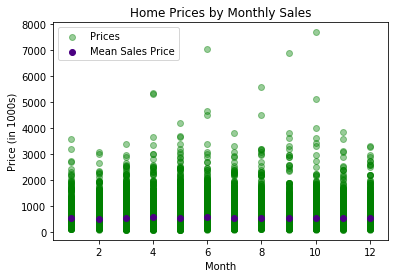

In [201]:
plt.scatter(temp_df.month_sold,temp_df.price/1000,color='green',alpha=0.4,label='Prices')
for x in range(1,12):
    plt.scatter(x, temp_df.price[temp_df.month_sold == x].mean()/1000, color='indigo')
    print(temp_df.price[temp_df.month_sold == x].mean())
plt.scatter(12, temp_df.price[temp_df.month_sold == 12].mean()/1000, color='indigo',label='Mean Sales Price')    
plt.xlabel('Month')
plt.ylabel('Price (in 1000s)')
plt.title('Home Prices by Monthly Sales')
plt.legend()
plt.show()

> Observations: Mean/Median home values do not change month to month

> Conclusion: There is no value in adding these features to the model
> since they do not explain price variations.

In [202]:
# drop irrelevant information

features_df.drop('yr_sold',axis=1,inplace=True)
features_df.drop('month_sold',axis=1,inplace=True)
features_df.drop('date',axis=1,inplace=True)

### Explore Correlated Variables

Finding correlations between variables is important at this stage to keep
in mind for the later analysis.

In [203]:
# this function returns a dataframe pinpointed correlated variables
# that exceed a correlation threshhold. 
def find_corr_vars(df, threshhold):
    
    threshhold = threshhold
    corr_vars0 = df.corr()
    print('Numbers of variables tested')
    print(len(corr_vars0.columns))
    corr_vars = (corr_vars0 > threshhold)
    length = len(corr_vars0.columns)
    print('Correlations tested:')
    print(corr_vars.size)
    print('Correlations meeting threshhold:')
    print(corr_vars.sum().sum() - length)

    rows=[]
    columns=[]
    for column in range(0,length):
        for row in range(0,length):
            if corr_vars.iloc[row][column] == True:
                rows.append(row)
                columns.append(column)
    corr1 = []
    corr2 = []
    words = list(corr_vars.columns)
    for index in rows:
        word = words[index]
        corr1.append(word)
    for index2 in columns:
        corr2.append(words[index2])

    corr_df = pd.DataFrame(data={'col1': corr1,'col2':corr2})
    print('')

    print('Correlated Variables over threshhold ' + str(threshhold))

    return corr_df[corr_df.col1 != corr_df.col2]

In [204]:
threshhold = 0.75 #set correlation threshhold minimum to filter correlations.
# let's find correlated variables above a certain threshhold
feat_price_df = features_df.join(price_df, how='left')
find_corr_vars(feat_price_df, threshhold).sort_values(by='col1',ascending=False)

Numbers of variables tested
19
Correlations tested:
361
Correlations meeting threshhold:
10

Correlated Variables over threshhold 0.75


,col1,col2
7,sqft_living15,sqft_living
2,sqft_living,bathrooms
13,sqft_living,grade
16,sqft_living,sqft_above
25,sqft_living,sqft_living15
6,sqft_above,sqft_living
15,sqft_above,grade
5,grade,sqft_living
17,grade,sqft_above
3,bathrooms,sqft_living


> Observation: We see here that sqft_living and correlated variables
> have a marked correlation with price even before processing the data

#### Set Categorical Variables / Reformat

#### 1. 'sqft_basement' feature

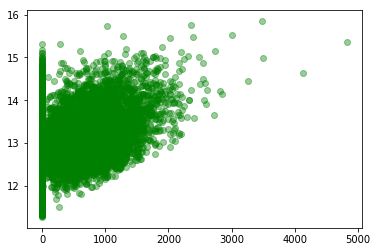

In [207]:
# tried to deal with this feature in various ways
# after dropping zeros, the feature correlated highly with sqft_living
# finally decided to make it a binary variable denoting presence of basement.
plt.scatter(features_df.sqft_basement,price_df.price,color='green',alpha=.4)

In [208]:
features_df['basement'] = round(features_df['sqft_basement'],0).astype(int)

d = {range(0,0):0, range(1,features_df.sqft_basement.max()):1}

features_df['basement'] = features_df['sqft_basement'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
features_df['basement'] = features_df['basement'].astype('category')

In [209]:
features_df['basement'].unique()

[0, 1]
Categories (2, int64): [0, 1]

#### 2. 'yr_sold' feature

In [210]:
# dropped from analysis due to nil contribution to price variations

#### 3. 'bathrooms' feature

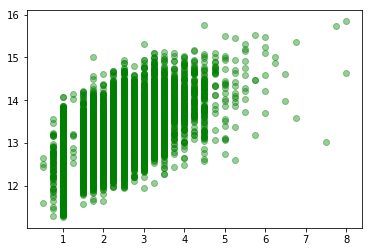

In [211]:
plt.scatter(features_df.bathrooms,price_df.price,color='green',alpha=.4)

In [212]:
# Initially, this variable was transformed to a category.
# For now, we will leave 'as is'

#### 4. 'waterfront' feature:

Waterfront Mean Price: 1717215.0
No Waterfront Mean Price: 530876.0


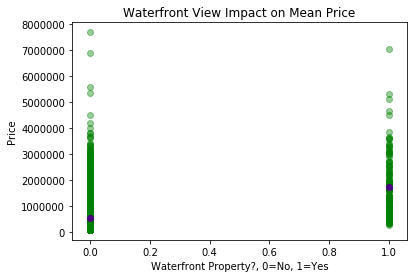

In [213]:
plt.scatter(temp_df.waterfront,temp_df.price,color='green',alpha=.4)
plt.scatter(0, (temp_df.price[temp_df.waterfront==0]).mean(),color='indigo')
plt.scatter(1, (temp_df.price[temp_df.waterfront==1]).mean(),color='indigo')
plt.xlabel('Waterfront Property?, 0=No, 1=Yes')
plt.ylabel('Price')
plt.title('Waterfront View Impact on Mean Price')
print('Waterfront Mean Price: ' + str(round((temp_df.price[temp_df.waterfront==1]).mean(),0)))
print('No Waterfront Mean Price: ' + str(round((temp_df.price[temp_df.waterfront==0]).mean(),0)))

> Waterfront properties are valued over a million dollars higher!

In [214]:
# fill NaN values in waterfront and view with zeros.
features_df.waterfront.fillna(0,inplace=True) # 10% of data was missing.
features_df['waterfront'] = features_df['waterfront'].astype(int).astype('category')

Waterfront Mean Price: 1717215.0
No Waterfront Mean Price: 530408.0


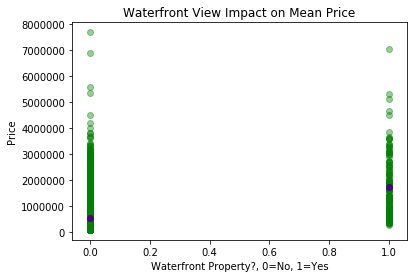

In [215]:
# check that changes did not impact distribution
temp_df.waterfront.fillna(0,inplace=True)
plt.scatter(temp_df.waterfront,temp_df.price,color='green',alpha=.4)
plt.scatter(0, (temp_df.price[temp_df.waterfront==0]).mean(),color='indigo')
plt.scatter(1, (temp_df.price[temp_df.waterfront==1]).mean(),color='indigo')
plt.xlabel('Waterfront Property?, 0=No, 1=Yes')
plt.ylabel('Price')
plt.title('Waterfront View Impact on Mean Price')
print('Waterfront Mean Price: ' + str(round((temp_df.price[temp_df.waterfront==1]).mean(),0)))
print('No Waterfront Mean Price: ' + str(round((temp_df.price[temp_df.waterfront==0]).mean(),0)))

> Filling NaN values did not affect the main conclusion about the waterfront feature.

#### 5. 'view' feature:

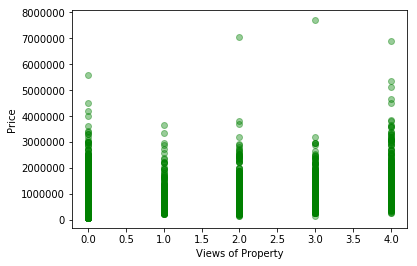

In [216]:
plt.scatter(features_df.view,df.price, color='green', alpha=0.4)
plt.xlabel('Views of Property')
plt.ylabel('Price')
plt.show()


In [217]:
features_df.drop('view',axis=1,inplace=True)
#features_df.view.fillna(0,inplace=True)       # less than 1% of data was missing.
#features_df['view'] = features_df['view'].astype(int).astype('category')


#### 6. 'bedrooms' feature:

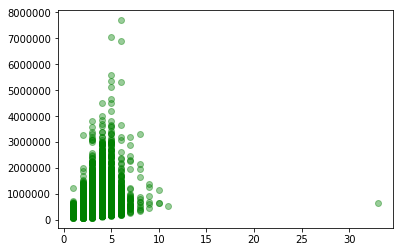

In [218]:
plt.scatter(features_df.bedrooms,df.price, color='green', alpha=0.4)

In [219]:
# initially set as category, changed it back to int

#replace type first to INT then to CATEGORY. No variables needed FLOAT type.
features_df['bedrooms'] = features_df['bedrooms'].astype(int)


#### 7. 'floors' feature:

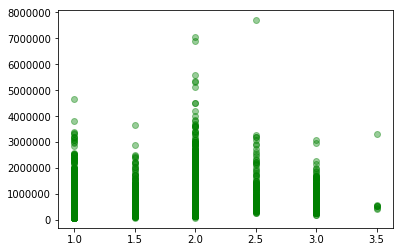

In [220]:
plt.scatter(features_df.floors,df.price, color='green', alpha=0.4)

In [221]:
# bin features and set as category
features_df['floors'] = round(features_df['floors'],0).astype(int)

d = {range(0,2):'1', range(2,4):'2plus'}

features_df['floors'] = features_df['floors'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
features_df['floors'] = features_df['floors'].astype('category')

#### 8. 'conditions' feature

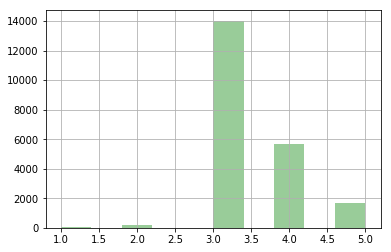

In [222]:
features_df['condition'].hist(color='green',alpha=.4)

In [223]:
# bin features and set as category

features_df['condition'] = features_df['condition'].astype(int)
d = {range(0,3):'poor', range(3,4):'average',range(4,6):'above_average'}
features_df['condition'] = features_df['condition'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))

features_df['condition'] = features_df['condition'].astype('category')

#### 9. 'zipcode' feature

In [224]:
features_df['zipcode'] = features_df['zipcode'].astype(int).astype('category')

# change a format for basement variable so that all sqft are int

#### 10. 'grade' feature:

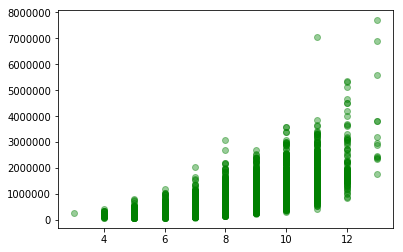

In [225]:
plt.scatter(features_df.grade,df.price, color='green', alpha=0.4)

In [226]:
# changed from category back to int
features_df['grade'] = features_df['grade'].astype(int)

#### 11. 'yr_renovated' feature:

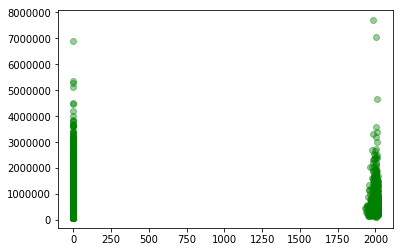

In [227]:
plt.scatter(features_df.yr_renovated,df.price, color='green', alpha=0.4)

In [228]:
# Create categories for renovations based on how recently they occurred.
# Assumption: More recent renovations drive the price up more.
# There are records of renovations that are more than 30 years old.
# For practicality, we will ignore this "old" renovations and only
# consider a house renovated if it was remodeled within the last 30 years.
features_df.yr_renovated.fillna(0,inplace=True)
features_df['yr_renovated'] = features_df['yr_renovated'].astype(int)
d = {range(0,2000):'no', range(2000, 2015):'recent'}

features_df['renovated'] = features_df['yr_renovated'].apply(lambda x: next((v for k, v in d.items() if x in k), 'no'))
features_df['renovated'] = features_df['renovated'].astype('category')

#drop yr_renovated from features_df
features_df.drop('yr_renovated',axis=1,inplace=True)
print('Most houses have not been remodeled recently.')

Most houses have not been remodeled recently.


#### 12. 'yr_built' feature

In [229]:
# Create a new feature called 'vintage' that will describe how recently
# a house was built.
d = {range(1900,1970):'Before70s',range(1970, 1980): '70s', range(1980, 1990): '80s', range(1990, 2000): '90s', range(2000, 2010): '2000s',range(2010, 2015): '2010s'}

features_df['built'] = features_df['yr_built'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
print('done')
features_df['built'] = features_df['built'].astype('category')

#drop the year built column, since we categorized it in bins
features_df.drop('yr_built',axis=1,inplace=True)
features_df['built'].head()


done


id
40000362      Before70s
8658300340    Before70s
3028200080    Before70s
3883800011    Before70s
1623049041    Before70s
Name: built, dtype: category
Categories (7, object): [0, 2000s, 2010s, 70s, 80s, 90s, Before70s]

#### 13. 'sqft_lot' feature:

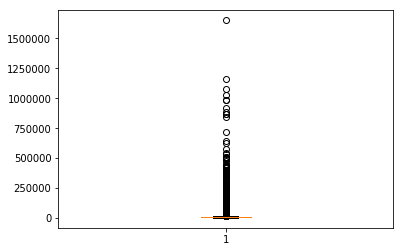

Skewness = 13.071695603822912
kurtosis = 285.4294421924969


In [230]:
plt.boxplot(features_df.sqft_lot)
plt.show()
print ('Skewness =', skew(features_df.sqft_lot))
print ('kurtosis =', kurtosis(features_df.sqft_lot))

Skewness = 0.9624335347705735
kurtosis = 3.328974148585477


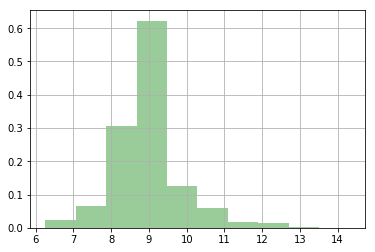

In [231]:
# Create a new feature to deal with lot size
# let's check out the distribution
features_df.sqft_lot = np.log(features_df.sqft_lot)
features_df.sqft_lot.hist(density=True,color='green',alpha=0.4)

print ('Skewness =', skew(features_df.sqft_lot))
print ('kurtosis =', kurtosis(features_df.sqft_lot))




Observations: improved the kurtosis, but it's still a bit high.

#### 14. and 15. 'lat' and 'long' features

> Using the lat lon variables, approximate the distance of houses to downtown seattle.

In [232]:
# calculate a proxy distance from seattle downtown
sea_lat  =  47.6050    # seattle's latitude in decimal degrees
sea_long = -122.3344   # seattle's longitude ''  ''      ''
lat_conv = 69.09       # approximate factor to convert decimal degrees to distance in miles
long_conv = 46.54      # gotten from http://www.csgnetwork.com/degreelenllavcalc.html

# go through latitude and longitude data and calculate component distance 
# from seattle.
features_df['sea_dist_lat'] = abs(sea_lat - features_df['lat'])*lat_conv
features_df['sea_dist_long'] = abs(sea_long - features_df['long'])*long_conv

# Using the components, calculate approximate distance using Pythagorean theorem.
features_df['approx_dist'] = np.sqrt((features_df['sea_dist_lat'])**2 + (features_df['sea_dist_long'])**2)



#### QC distance approximation

> Calculating distances using this method is a crude approximation.

> It is necessary to check whether the results make sense geographically.

> Calculations were validated by mapping the data and researching distances manually.

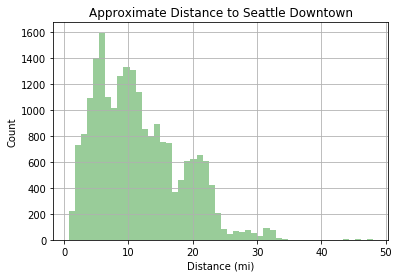

In [233]:
# First QC tool: generate a histogram of distances from the city center
# to the various houses. 
features_df.approx_dist.hist(bins=50,color='green',alpha=.4)
plt.xlabel('Distance (mi)')
plt.ylabel('Count')
plt.title('Approximate Distance to Seattle Downtown')
plt.show()

In [234]:
# Based on this histogram, when we plot a heatmap of locations, most
# houses should be located within a 10-15 radius of the city center.

#### Plot heatmap of location values

In [235]:
# Use the folium utility to create a house density map.
# we used the original lat and long values to determine whether most
# houses are located very near Seattle.

def map_values(center_lat, center_long, df):
   
    m = folium.Map([center_lat,center_long], zoom_start=10)
    folium.Marker([center_lat,center_long]).add_to(m)

    locations = df[['lat', 'long']]
    locationlist = locations.values.tolist()
    m.add_children(plugins.HeatMap(locationlist, radius=20, min_opacity=0.25))
    return m

In [236]:
map_values(sea_lat,sea_long,df)

In [237]:
# Yes, after validating our data using this and outside map
# we can include this distance approximation in our analysis.

In [238]:
# reformat / drop columns 
features_df.drop('sea_dist_long',axis=1,inplace=True)
features_df.drop('sea_dist_lat',axis=1,inplace=True)
features_df.drop('lat',axis=1,inplace=True)
features_df.drop('long',axis=1,inplace=True)
features_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,basement,renovated,built,approx_dist
id,,,,,,,,,,,,,,,,,
40000362,2,1.00,780,9.701616,1,0,poor,5,780,0,98168,1700,10387,0,no,Before70s,9.404882
8658300340,1,0.75,430,8.527144,1,0,poor,4,430,0,98014,1200,7500,0,no,Before70s,20.039678
3028200080,2,1.00,730,9.207837,1,0,poor,5,730,0,98168,860,9000,0,no,Before70s,8.628347
3883800011,3,1.00,860,9.252058,1,0,average,6,860,0,98146,1140,11250,0,no,Before70s,7.350688
1623049041,2,1.00,520,10.013865,1,0,poor,5,520,0,98168,1572,10570,0,no,Before70s,8.825987


#### Check data info again


In [239]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 17 columns):
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null float64
floors           21597 non-null category
waterfront       21597 non-null category
condition        21597 non-null category
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
zipcode          21597 non-null category
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
basement         21597 non-null category
renovated        21597 non-null category
built            21597 non-null category
approx_dist      21597 non-null float64
dtypes: category(7), float64(3), int64(7)
memory usage: 2.6 MB


In [240]:
features_df.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,approx_dist
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,3.373200,2.115826,2080.321850,8.989805,7.657915,1788.596842,285.716581,1986.620318,12758.283512,11.492200
std,0.926299,0.768984,918.106125,0.902078,1.173200,827.759761,439.819830,685.230472,27274.441950,6.594342
min,1.000000,0.500000,370.000000,6.253829,3.000000,370.000000,0.000000,399.000000,651.000000,0.716749
25%,3.000000,1.750000,1430.000000,8.525161,7.000000,1190.000000,0.000000,1490.000000,5100.000000,6.108846
50%,3.000000,2.250000,1910.000000,8.938269,7.000000,1560.000000,0.000000,1840.000000,7620.000000,10.326178
75%,4.000000,2.500000,2550.000000,9.276596,8.000000,2210.000000,550.000000,2360.000000,10083.000000,15.734412
max,33.000000,8.000000,13540.000000,14.317109,13.000000,9410.000000,4820.000000,6210.000000,871200.000000,48.026074


#### Create heatmaps and correlation matrix

In [241]:
features_df.corr()>.8

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,approx_dist
bedrooms,True,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False
sqft_living,False,False,True,False,False,True,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False,False
sqft_above,False,False,True,False,False,True,False,False,False,False
sqft_basement,False,False,False,False,False,False,True,False,False,False
sqft_living15,False,False,False,False,False,False,False,True,False,False
sqft_lot15,False,False,False,False,False,False,False,False,True,False
approx_dist,False,False,False,False,False,False,False,False,False,True


####  16 , 17, 18 : 'sqft_living' , 'sqft_above' , 'sqft_living15' features

>  These variables are correlated over 70% of the time.
>  Let's choose only one for our model. The best correlated with price!

In [242]:
# calculate correlations with target values for correlated variables
# to choose the best for our model
corr_columns = ['sqft_living','sqft_living15','sqft_above']
df_corr = price_df.join(features_df[corr_columns],how='left')
df_corr.corr()

,price,sqft_living,sqft_living15,sqft_above
price,1.000000,0.695067,0.620297,0.601720
sqft_living,0.695067,1.000000,0.756843,0.876282
sqft_living15,0.620297,0.756843,1.000000,0.731540
sqft_above,0.601720,0.876282,0.731540,1.000000


In [243]:
# based on these results, we will nix:  sqft_abovve

In [244]:
features_df.drop('sqft_above',axis=1,inplace=True)
#we had dropped more features with a threshhold of .75

In [245]:
# transform to float
features_df['sqft_living'] = features_df['sqft_living'].astype(float)

#### 19 sqft_lot15 and sqft_lot

In [246]:
#dropped these before
#features_df.drop('sqft_lot15',axis=1,inplace=True)

In [247]:
# Remaining correlations
features_df.corr()>.8

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_basement,sqft_living15,sqft_lot15,approx_dist
bedrooms,True,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False
sqft_living,False,False,True,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False
sqft_basement,False,False,False,False,False,True,False,False,False
sqft_living15,False,False,False,False,False,False,True,False,False
sqft_lot15,False,False,False,False,False,False,False,True,False
approx_dist,False,False,False,False,False,False,False,False,True


In [248]:
# Looks good, no remaining strong correlations!
# for now we will keep these

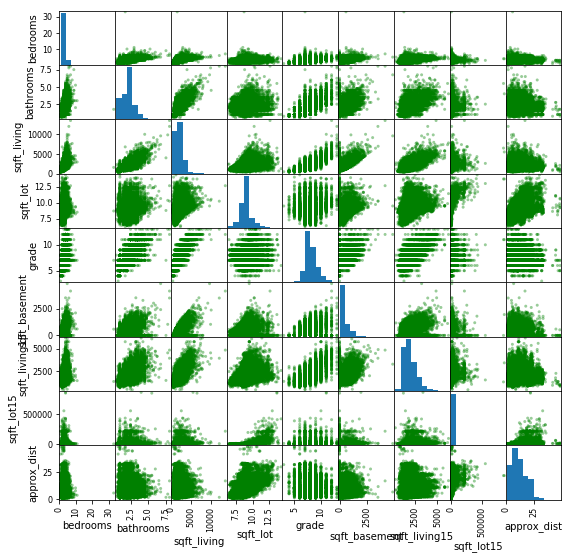

In [249]:
pd.plotting.scatter_matrix(features_df,figsize  = [9, 9], color='green',alpha=0.4)
plt.show()

#### Dummy variables


In [250]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 16 columns):
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null float64
sqft_lot         21597 non-null float64
floors           21597 non-null category
waterfront       21597 non-null category
condition        21597 non-null category
grade            21597 non-null int64
sqft_basement    21597 non-null int64
zipcode          21597 non-null category
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
basement         21597 non-null category
renovated        21597 non-null category
built            21597 non-null category
approx_dist      21597 non-null float64
dtypes: category(7), float64(4), int64(5)
memory usage: 2.4 MB


In [252]:
features_df['bedrooms'] = features_df['bedrooms'].astype('float')
features_df['grade'] = features_df['grade'].astype('float')
features_df['sqft_basement'] = features_df['sqft_basement'].astype('category')
features_df['sqft_living15'] = features_df['sqft_living15'].astype('float')
features_df['sqft_lot15'] = features_df['sqft_lot15'].astype('float')

In [253]:
#features_df = features_df.drop(cat_vars, axis=1)

#bed= pd.get_dummies(features_df['bedrooms'], prefix="bed")
#bath= pd.get_dummies(features_df['bathrooms'], prefix="bath")
floor= pd.get_dummies(features_df['floors'], prefix="flo")
water= pd.get_dummies(features_df['waterfront'], prefix="water")
#view= pd.get_dummies(features_df['view'], prefix="view")
cond = pd.get_dummies(features_df['condition'], prefix="cond")
#grade= pd.get_dummies(features_df['grade'], prefix="grade")
zipc= pd.get_dummies(features_df['zipcode'], prefix="zip")
#sold= pd.get_dummies(features_df['yr_sold'], prefix="sold")
renov = pd.get_dummies(features_df['renovated'], prefix="renov")
built = pd.get_dummies(features_df['built'], prefix="built")
base = pd.get_dummies(features_df['basement'], prefix="base")

In [254]:

features_df = pd.concat([features_df,floor,water,cond,renov,built,zipc],axis=1) #drop bed bath drop grade as test
features_df.shape

# drop categorical variables written before hot encoding
cat_vars = ['floors','basement','sqft_basement','waterfront','condition','zipcode','renovated','built']
features_df.drop(cat_vars,axis=1,inplace=True)

In [255]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 95 columns):
bedrooms              21597 non-null float64
bathrooms             21597 non-null float64
sqft_living           21597 non-null float64
sqft_lot              21597 non-null float64
grade                 21597 non-null float64
sqft_living15         21597 non-null float64
sqft_lot15            21597 non-null float64
approx_dist           21597 non-null float64
flo_0                 21597 non-null uint8
flo_1                 21597 non-null uint8
flo_2plus             21597 non-null uint8
water_0               21597 non-null uint8
water_1               21597 non-null uint8
cond_above_average    21597 non-null uint8
cond_average          21597 non-null uint8
cond_poor             21597 non-null uint8
renov_no              21597 non-null uint8
renov_recent          21597 non-null uint8
built_0               21597 non-null uint8
built_2000s           21597 non-null uint8
bui

#### Normalize values

In [256]:
# normalize continuous features in dataframe
column = 'bedrooms'
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column = 'bathrooms'
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column = 'grade'
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()


column ='sqft_living'
features_df[column] = np.log(features_df[column])
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column ='sqft_living15'
features_df[column] = np.log(features_df[column])
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column ='approx_dist'
features_df[column] = np.log(features_df[column])
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column ='sqft_lot'
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column ='sqft_lot15'
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()


In [257]:
features_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_living15,sqft_lot15,approx_dist,flo_0,flo_1,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
id,,,,,,,,,,,,,,,,,,,,,
40000362,-1.482459,-1.451039,-2.101474,0.789080,-2.265527,-0.308765,-0.086942,-0.018108,0,1,...,0,0,0,0,1,0,0,0,0,0
8658300340,-2.562024,-1.776143,-3.505344,-0.512884,-3.117897,-1.372403,-0.192792,1.133406,0,1,...,0,0,0,0,0,0,0,0,0,0
3028200080,-1.482459,-1.451039,-2.257653,0.241700,-2.265527,-2.389740,-0.137795,-0.149285,0,1,...,0,0,0,0,1,0,0,0,0,0
3883800011,-0.402894,-1.451039,-1.871299,0.290721,-1.413157,-1.529040,-0.055300,-0.393229,0,1,...,1,0,0,0,0,0,0,0,0,0
1623049041,-1.482459,-1.451039,-3.057329,1.135224,-2.265527,-0.547810,-0.080232,-0.114811,0,1,...,0,0,0,0,1,0,0,0,0,0


#### Check Linearity Assumptions

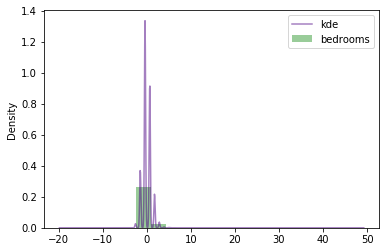

Skewness = 2.023500682470702
kurtosis = 49.81002325740023


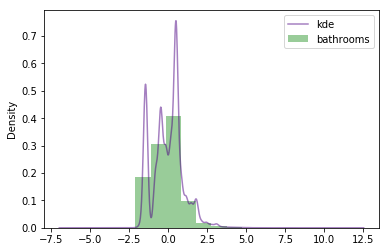

Skewness = 0.5196731850083091
kurtosis = 1.2787413307385336


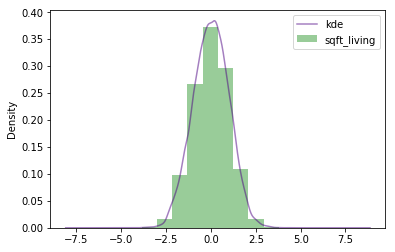

Skewness = -0.027360069339444994
kurtosis = -0.07929775335686351


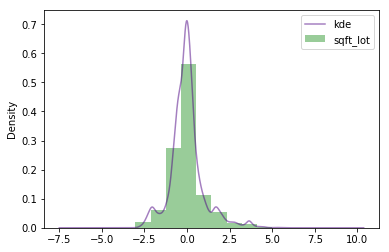

Skewness = 0.9624335347705764
kurtosis = 3.328974148585484


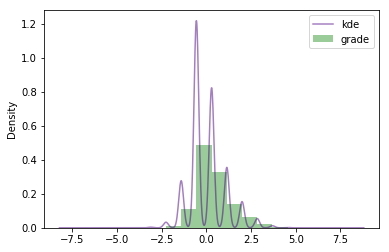

Skewness = 0.7881818890694116
kurtosis = 1.1346074335227243


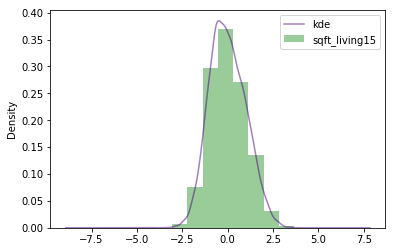

Skewness = 0.205963270751976
kurtosis = -0.20828561479785312


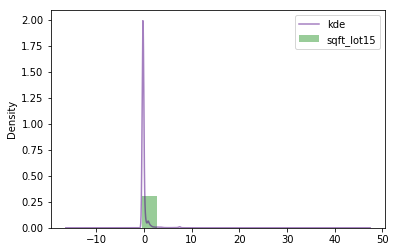

Skewness = 9.523700446454049
kurtosis = 151.36033683166409


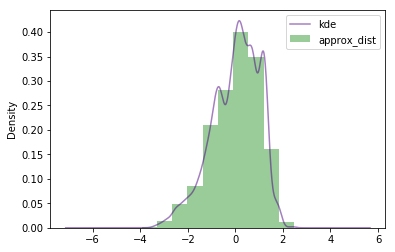

Skewness = -0.598212714437572
kurtosis = 0.004374917825920477


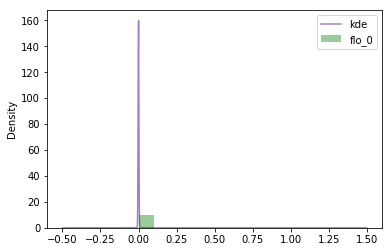

Skewness = 55.5183396591603
kurtosis = 3080.2860385098907


In [258]:
# check distributions for the 3 continuous variables

for column in features_df.iloc[:,0:9]:
    features_df[column].plot.hist(normed=True,color='green',alpha=0.4,label=column, range=(features_df[column].min(),features_df[column].max()))
    features_df[column].plot.kde(label='kde',color='indigo',alpha=0.5)
    plt.legend()
    plt.show()
    print ('Skewness =', skew(features_df[column]))
    print ('kurtosis =', kurtosis(features_df[column]))
    
    
    
    

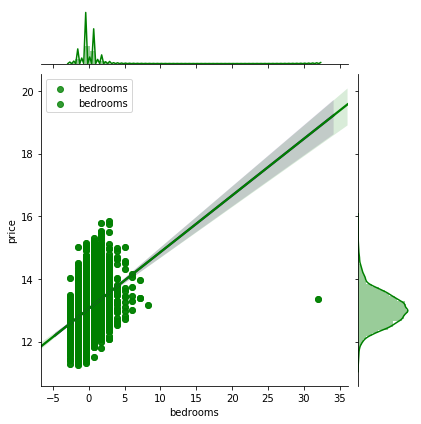

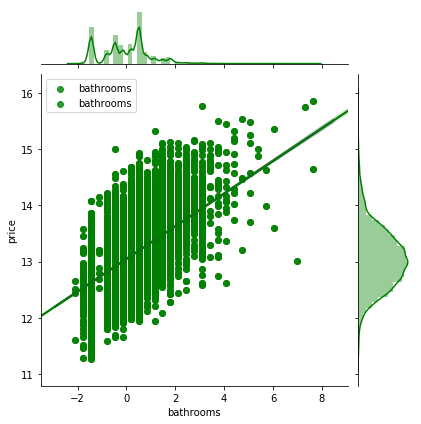

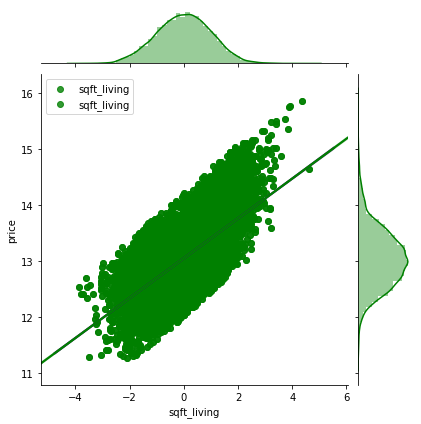

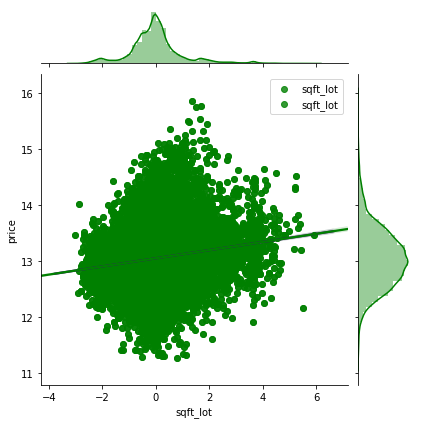

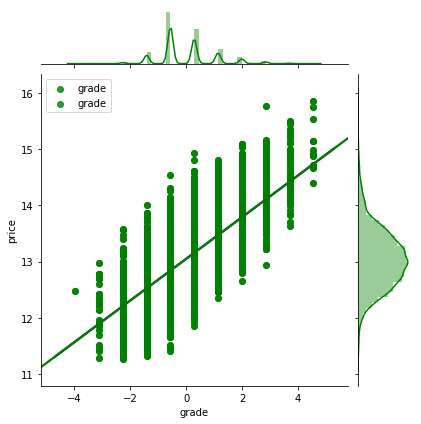

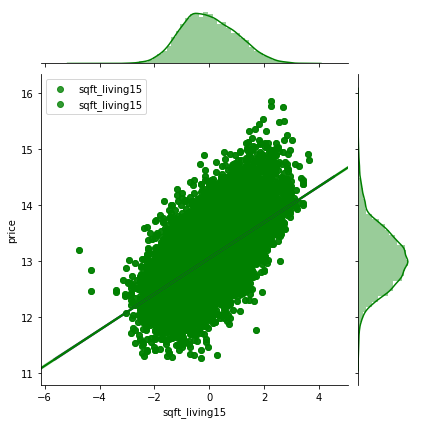

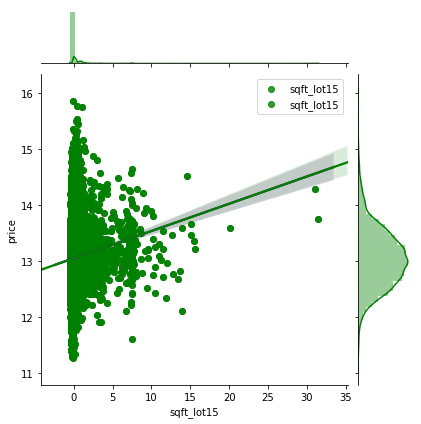

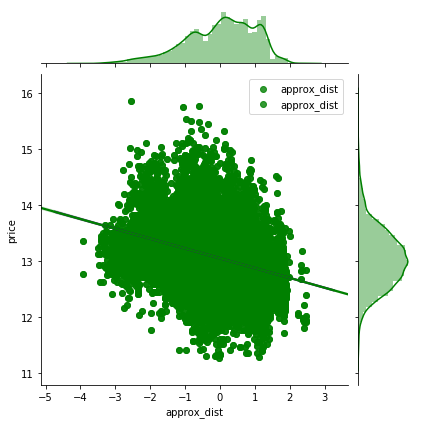

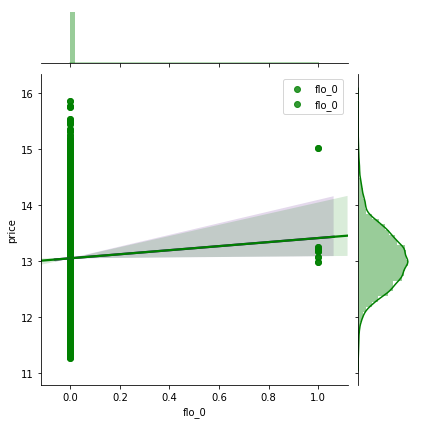

In [259]:
temp_price = price_df['price']
for column in features_df.iloc[:,0:9]:
    sns.jointplot(x=column, y=temp_price,
                  data=features_df, 
                  kind='reg', 
                  color = 'green',
                  label=column,
                  joint_kws={'line_kws':{'color':'indigo'}})
    sns.regplot(features_df[column], temp_price, label=column, color='green')
    plt.legend()
    plt.show()

#### Run first model and identify opportunities for improvement.

### Run Linear Regression for Feature Selection

In [260]:
# returns a dataframe with regression information per variable.
# df is the dataframe containing features
# price_df is the dataframe containing the target
# pvalue is the maximum p-value accepted.

def run_single_linreg(df, price_df,pvalue):
    col_names = df.columns
    data_df = price_df.join(df,how='left')

    results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
    for val in (col_names):
        f = 'price~' + val
        model = smf.ols(formula=f, data=data_df).fit()
        X_new = pd.DataFrame({val: [data_df[val].min(), data_df[val].max()]});
        preds = model.predict(X_new)
        results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1] ])
    results_df = pd.DataFrame(results, columns=results[0])
    results_df.drop(0,inplace=True)
    results_df.set_index('ind_var',inplace=True)
    results_df = results_df[results_df['p-value']<=pvalue]
    return results_df
    

In [261]:
single_linreg_1 = run_single_linreg(features_df, price_df,0.05)
single_linreg_1.sort_values('r_squared',ascending=False).head()

,r_squared,intercept,slope,p-value
ind_var,,,,
grade,0.496262,13.0465,0.371929,0
sqft_living,0.456005,13.0458,0.357064,0
sqft_living15,0.37019,13.0452,0.321857,0
bathrooms,0.304708,13.0454,0.291872,0
bedrooms,0.116518,13.0437,0.18028,0


### PREDICTORS: 1st Pass

In [262]:
# features selected as 1st pass
predictors1 = list(single_linreg_1.index)
len(predictors1)

features_df = features_df[predictors1]

### Run Multiple Linear Regression Model #1

In [263]:
# This function takes features (predictors) inside a dataframe (df)
# and creates the best fit to explain the 'price' (price_df)

def run_mult_linreg(df, price_df, predictors):
    y = price_df.price
    X = df[predictors]
    n_predictors = len(predictors)
    linreg = LinearRegression()
    r_list = []
    adj_r_list = []
    list_n = list(range(n_predictors//2,n_predictors))  #n predictors calculated above
    for n in list_n: 
        select_n = RFE(linreg, n_features_to_select = n)
        select_n = select_n.fit(X, np.ravel(y))
        selected_columns = X.columns[select_n.support_ ]
        linreg.fit(X[selected_columns],y)
        yhat = linreg.predict(X[selected_columns])
        SS_Residual = np.sum((y-yhat)**2)
        SS_Total = np.sum((y-np.mean(y))**2)
        r_squared = 1 - (float(SS_Residual))/SS_Total
        print(r_squared)
        adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    r_list.append(r_squared)
    adj_r_list.append(adjusted_r_squared)
    print('r-squared: ' + str(r_list))
    print('adj r-squared: ' + str(adj_r_list))
    return linreg

In [264]:
# Run the first linear regression and print r-squared values
mult_linreg1 = run_mult_linreg(features_df,price_df,predictors1)

0.8008413687226479
0.8029993555177772
0.8065697812832961
0.8079507309174121
0.8087760527674648
0.8409738694350076
0.8413609015135799
0.842040193527845
0.8433141502572007
0.843728343136195
0.8444693306577171
0.8449727212436735
0.8452651039918444
0.845569098776112
0.8456988482731019
0.8457375062137766
0.8559328588756429
0.8561165410666727
0.8686673183170173
0.8697620203541221
0.8701170907437825
0.870246876580237
0.8703715811433688
0.8747812141499305
0.8749222986331492
0.8770684891086756
0.8770764178005714
0.8771439149916956
0.877201616340666
0.8777840621802745
0.8778970756519323
0.8778971420800004
0.87817865274203
0.8781940841115046
0.8787926836418063
0.878920281525758
0.8789323401162241
0.8789490043356714
0.87895069535972
0.8793649290969594
0.879369491699513
0.87956998487209
0.8684237294098619
r-squared: [0.8684237294098619]
adj r-squared: [0.8678976690067586]


#### Cross Validation Scores

In [265]:
def run_cross_validation(linreg,df, price_df, predictors,cv_number):
    y = price_df.price
    X = df[predictors]
    n_predictors = len(list(predictors))
    select_n = RFE(linreg, n_features_to_select = n_predictors)
    select = select_n.fit(X, np.ravel(y))
    selected_columns = X.columns[select_n.support_]

    cv_10_results = cross_val_score(linreg, X[selected_columns], y, cv=10, scoring="neg_mean_squared_error")
    print(str(n_predictors) + ' predictors used.')
    print(cv_10_results)

In [266]:
run_cross_validation(mult_linreg1,features_df,price_df,predictors1,10)

86 predictors used.
[-0.09212391 -0.02998748 -0.02681373 -0.02815491 -0.02703594 -0.02768028
 -0.02533675 -0.02673913 -0.03084799 -0.10368264]


In [267]:
# Large cross-validation values indicate multicollinearity issues!

In [268]:
def run_ols_model(df, price_df,predictors):
    data_df = price_df.join(df,how='left')
    outcome = 'price'

    data_df.info()
    predictors_list = '+'.join(list(predictors))

    formula = outcome + "~" + predictors_list
    model = ols(formula=formula, data=data_df).fit()
    return(model)

In [269]:
ols_model_1 = run_ols_model(features_df,price_df,predictors1)
ols_model_1.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 1000102 to 9900000190
Data columns (total 87 columns):
price              21953 non-null float64
bedrooms           21953 non-null float64
bathrooms          21953 non-null float64
sqft_living        21953 non-null float64
sqft_lot           21953 non-null float64
grade              21953 non-null float64
sqft_living15      21953 non-null float64
sqft_lot15         21953 non-null float64
approx_dist        21953 non-null float64
flo_1              21953 non-null uint8
flo_2plus          21953 non-null uint8
water_0            21953 non-null uint8
water_1            21953 non-null uint8
cond_average       21953 non-null uint8
cond_poor          21953 non-null uint8
renov_no           21953 non-null uint8
renov_recent       21953 non-null uint8
built_0            21953 non-null uint8
built_2000s        21953 non-null uint8
built_2010s        21953 non-null uint8
built_70s          21953 non-null uint8
built_90s          219

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     1864.
Date:                Sat, 08 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:19:39   Log-Likelihood:                 5866.2
No. Observations:               21953   AIC:                        -1.156e+04
Df Residuals:                   21868   BIC:                        -1.088e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7016      0.036    188.044      0.000       6.632       6.771
bedrooms           -0.0150      0.002     -8.824      0.000      -0.018      -0.012
bathrooms           0.0282      0.002     12.381      0.000       0.024       0.033
sqft_living         0.1572      0.003     54.173      0.000       0.152       0.163
sqft_lot            0.0851      0.002     35.091      0.000       0.080       0.090
grade               0.1185      0.002     51.719      0.000       0.114       0.123
sqft_living15       0.0598      0.002     27.586      0.000       0.056       0.064
sqft_lot15         -0.0104      0.002     -5.924      0.000      -0.014      -0.007
approx_dist        -0.1832      0.006    -29.443      0.000      -0.195      -0.171
flo_1               0.0381      0.070      0.541      0.589      -0.100       0.176
flo_2plus           0.0503      0.070      0.715      0.474      -0.088       0.188
water_0             3.0200      0.019    161.673      0.000       2.983       3.057
water_1             3.6816      0.020    181.960      0.000       3.642       3.721
cond_average       -0.0625      0.003    -19.966      0.000      -0.069      -0.056
cond_poor          -0.2063      0.013    -15.981      0.000      -0.232      -0.181
renov_no            3.2871      0.018    181.192      0.000       3.251       3.323
renov_recent        3.4146      0.019    180.523      0.000       3.377       3.452
built_0             0.0261      0.031      0.853      0.394      -0.034       0.086
built_2000s         0.0350      0.006      6.103      0.000       0.024       0.046
built_2010s         0.1053      0.007     14.480      0.000       0.091       0.120
built_70s          -0.0189      0.006     -3.316      0.001      -0.030      -0.008
built_90s           0.0064      0.006      1.115      0.265      -0.005       0.018
built_Before70s     0.0289      0.005      5.574      0.000       0.019       0.039
zip_98001          -0.2840      0.012    -23.644      0.000      -0.308      -0.260
zip_98002          -0.2495      0.015    -16.511      0.000      -0.279      -0.220
zip_98003          -0.2601      0.013    -20.051      0.000      -0.286      -0.235
zip_98004           0.5127      0.013     39.808      0.000       0.487       0.538
zip_98005           0.1700      0.016     10.931      0.000       0.140       0.201
zip_98006           0.1662      0.010     17.002      0.000       0.147       0.185
zip_98007           0.1393      0.016      8.544      0.000       0.107       0.171
zip_98008           0.2024      0.012     16.727      0.000       0.179       0.226
zip_98010          -0.0006      0.020     -0.028      0.978      -0.040       0.039
zip_98014           0.0396      0.018      2.158      0.031       0.004       0.076
zip_98019           0.0177      0.015      1.167      0.243

> Observation: There are multicollinearity issues... Need to remove binary categories or other correlated variables.

> Bedrooms is negatively correlated!

### ANALYSIS

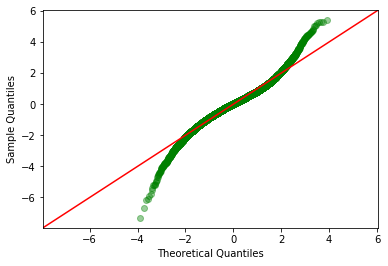

In [270]:
fig = sm.graphics.qqplot(ols_model_1.resid, dist=stats.norm, line=('45'), fit=True,color='green',alpha=.4)



> Variables behave linearly for about 2 standard deviations from the mean in each direction


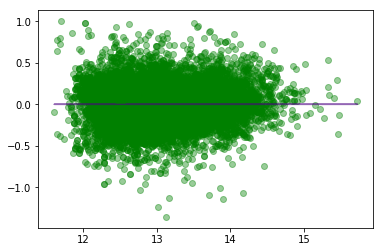

In [271]:
data_df1 = price_df.join(features_df,how='left')
plt.scatter(ols_model_1.predict(data_df1), ols_model_1.resid,color='green',alpha=.4)
plt.plot(ols_model_1.predict(data_df1), [0 for i in range(len(data_df1))],color='indigo',alpha=.6)
                                                      
                                                      

> Overall this is a good result.

## ITERATION 2

### Explore Variable Relationships

#### Bedrooms vs. Living Area

Text(0, 0.5, 'Living Area (sqft)')

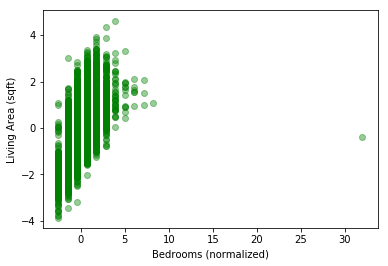

In [272]:
plt.scatter(features_df.bedrooms,features_df.sqft_living,color='green',alpha=0.4)
plt.xlabel('Bedrooms (normalized)')
plt.ylabel('Living Area (sqft)')

This datapoint (33 bedrooms) looks like a typing error. Maybe they meant 3 bedrooms

In [273]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [274]:
# let's find out this datapoint in the dataframe
features_df.loc[df['bedrooms'] == 33]

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_living15,sqft_lot15,approx_dist,flo_1,flo_2plus,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
id,,,,,,,,,,,,,,,,,,,,,
2402100895,31.984061,-0.475727,-0.378459,-0.321801,-0.560787,-1.058303,-0.295452,-0.774277,1,0,...,0,0,0,0,0,0,0,0,0,0


In [275]:
df.loc[df['bedrooms'] == 11]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
1773100755,8/21/2014,520000.0,11,3.0,3000,4960,2.0,0.0,0.0,3,7,2400,600.0,1918,1999.0,98106,47.556,-122.363,1420,4960


In [276]:
df.loc[df['bedrooms'] == 10]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
5566100170,10/29/2014,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,4,7,3010,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914
8812401450,12/29/2014,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,4,7,1860,1060.0,1913,0.0,98105,47.6635,-122.320,1810,3745
627300145,8/14/2014,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,3,9,2500,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400


It is clear this was a typo, a house with 1620 sqft cannot have 33 bedrooms

In [277]:
# Let's replace this value with the log value for 3, which is the median
value = (3 - df.bedrooms.mean()) / df.bedrooms.std()
features_df.loc[2402100895,'bedrooms'] = value
features_df.loc[1773100755,'bedrooms'] = value
features_df.loc[5566100170,'bedrooms'] = value

Text(0, 0.5, 'Living Area (sqft)')

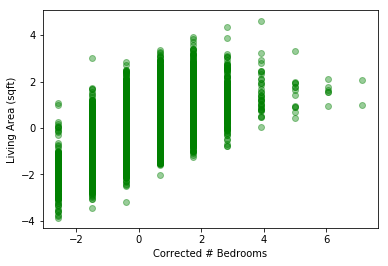

In [278]:
plt.scatter(features_df.bedrooms,features_df.sqft_living, color='green',alpha=0.4)
plt.xlabel('Corrected # Bedrooms')
plt.ylabel('Living Area (sqft)')

> Much better!

#### Remove Binary / Singular Categories

In [279]:
features_df.drop('water_0',axis=1,inplace=True)  # Remove no waterfront
features_df.drop('renov_no',axis=1,inplace=True) # Remove no renovations



In [280]:
features_df.drop('flo_1',axis=1,inplace=True)


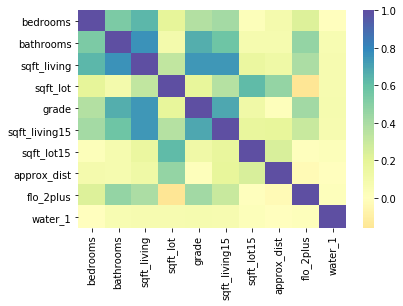

In [281]:
sns.heatmap(features_df.corr().iloc[0:10,0:10], center=0, cmap='Spectral');

In [282]:
features_df.corr().iloc[0:30]>.7

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_living15,sqft_lot15,approx_dist,flo_2plus,water_1,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
bedrooms,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,True,True,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
grade,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living15,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_lot15,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
approx_dist,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
flo_2plus,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
water_1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [283]:
features_df.drop('bathrooms',axis=1,inplace=True)
features_df.drop('bedrooms',axis=1,inplace=True)

In [284]:
features_df.drop('sqft_living15',axis=1,inplace=True)
features_df.drop('grade',axis=1,inplace=True)

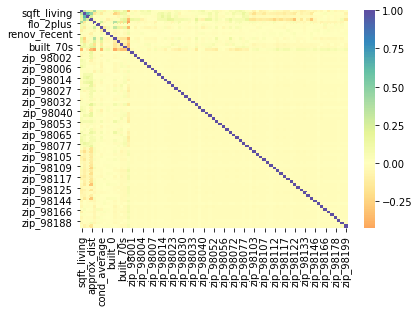

In [285]:
sns.heatmap(features_df.corr(), center=0, cmap='Spectral');

### Run Second Iteration

In [286]:
linreg2 = run_single_linreg(features_df, price_df,0.05)
predictors2 = list(linreg2.index)
features_df = features_df[predictors2]
len(predictors2)

79

In [287]:
mult_linreg2 = run_mult_linreg(features_df, price_df, predictors2)

0.7783441770543799
0.7801254137770448
0.7815999955202008
0.7835760542614375
0.784902877972133
0.785643770721059
0.786062687646415
0.7866968857905484
0.7870221330432253
0.7872597200988718
0.7873983463476607
0.7874557173562381
0.8247897110399928
0.8259765401424533
0.8267367883992064
0.8279449150754653
0.8284364474104469
0.8293746153123155
0.8300568140400838
0.8302297495412408
0.8307822693526057
0.831271524032221
0.8446736846541281
0.8448794970306597
0.8452182787560458
0.8460398032584047
0.848494410240163
0.8485897574883023
0.8487307633371131
0.8489011566468782
0.8489048841472462
0.8494744744113651
0.8509885104926875
0.8514579391989165
0.8514701388841295
0.8514994355977606
0.8515101481617482
0.8516733067695711
0.8516919151760066
0.8520462596104622
r-squared: [0.8520462596104622]
adj r-squared: [0.8515030451525558]


In [288]:
run_cross_validation(mult_linreg2,features_df,price_df,predictors2,10)

79 predictors used.
[-0.09442115 -0.03465775 -0.03291423 -0.03360321 -0.03422773 -0.03509301
 -0.03170923 -0.03352768 -0.03554502 -0.16038599]


In [289]:
ols_model_2 = run_ols_model(features_df,price_df,predictors2)
ols_model_2.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 1000102 to 9900000190
Data columns (total 80 columns):
price              21953 non-null float64
sqft_living        21953 non-null float64
sqft_lot           21953 non-null float64
sqft_lot15         21953 non-null float64
approx_dist        21953 non-null float64
flo_2plus          21953 non-null uint8
water_1            21953 non-null uint8
cond_average       21953 non-null uint8
cond_poor          21953 non-null uint8
renov_recent       21953 non-null uint8
built_0            21953 non-null uint8
built_2000s        21953 non-null uint8
built_2010s        21953 non-null uint8
built_70s          21953 non-null uint8
built_90s          21953 non-null uint8
built_Before70s    21953 non-null uint8
zip_98001          21953 non-null uint8
zip_98002          21953 non-null uint8
zip_98003          21953 non-null uint8
zip_98004          21953 non-null uint8
zip_98005          21953 non-null uint8
zip_98006          21953 non-n

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1569.
Date:                Sat, 08 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:20:26   Log-Likelihood:                 3647.4
No. Observations:               21953   AIC:                            -7135.
Df Residuals:                   21873   BIC:                            -6495.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.0498      0.008   1731.114      0.000      13.035      13.065
sqft_living         0.2606      0.002    137.146      0.000       0.257       0.264
sqft_lot            0.1110      0.003     42.094      0.000       0.106       0.116
sqft_lot15         -0.0137      0.002     -7.047      0.000      -0.018      -0.010
approx_dist        -0.2049      0.007    -29.810      0.000      -0.218      -0.191
flo_2plus           0.0191      0.004      5.115      0.000       0.012       0.026
water_1             0.7438      0.017     43.052      0.000       0.710       0.778
cond_average       -0.0548      0.003    -15.868      0.000      -0.062      -0.048
cond_poor          -0.2304      0.014    -16.156      0.000      -0.258      -0.202
renov_recent        0.1517      0.011     13.578      0.000       0.130       0.174
built_0             0.0916      0.034      2.709      0.007       0.025       0.158
built_2000s         0.0867      0.006     13.804      0.000       0.074       0.099
built_2010s         0.1634      0.008     20.484      0.000       0.148       0.179
built_70s          -0.0571      0.006     -9.150      0.000      -0.069      -0.045
built_90s           0.0495      0.006      7.843      0.000       0.037       0.062
built_Before70s    -0.0491      0.005     -9.044      0.000      -0.060      -0.038
zip_98001          -0.3013      0.013    -22.696      0.000      -0.327      -0.275
zip_98002          -0.3001      0.017    -18.006      0.000      -0.333      -0.267
zip_98003          -0.2343      0.014    -16.349      0.000      -0.262      -0.206
zip_98004           0.6009      0.014     42.385      0.000       0.573       0.629
zip_98005           0.2598      0.017     15.154      0.000       0.226       0.293
zip_98006           0.2681      0.011     25.081      0.000       0.247       0.289
zip_98007           0.1905      0.018     10.587      0.000       0.155       0.226
zip_98008           0.2416      0.013     18.083      0.000       0.215       0.268
zip_98010          -0.0345      0.022     -1.544      0.123      -0.078       0.009
zip_98014          -0.0039      0.020     -0.192      0.848      -0.044       0.036
zip_98019          -0.0229      0.017     -1.368      0.171      -0.056       0.010
zip_98022          -0.0979      0.018     -5.521      0.000      -0.133      -0.063
zip_98023          -0.2675      0.012    -22.200      0.000      -0.291      -0.244
zip_98027           0.1711      0.012     14.809      0.000       0.148       0.194
zip_98029           0.3221      0.013     24.608      0.000       0.296       0.348
zip_98030          -0.2933      0.014    -20.403      0.000      -0.321      -0.265
zip_98031          -0.2940      0.014    -21.428      0.000      -0.321      -0.267
zip_98032          -0.3535      0.019    -18.460      0.000

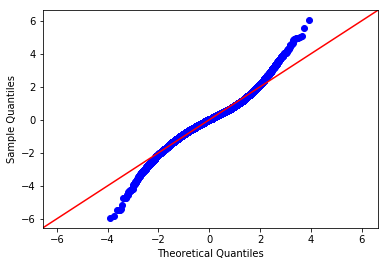

In [290]:
fig = sm.graphics.qqplot(ols_model_2.resid, dist=stats.norm, line='45', fit=True)

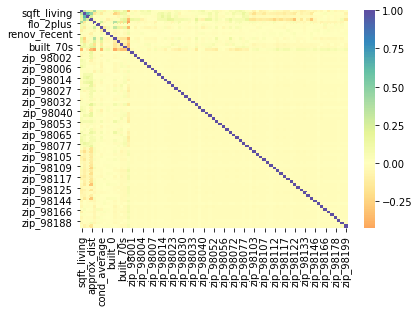

In [291]:
sns.heatmap(features_df.corr(), center=0, cmap='Spectral');

### Run 3rd Iteration

In [292]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [293]:
predictors3 = stepwise_selection(features_df, price_df)

Add  approx_dist                    with p-value 0.0
Add  sqft_lot                       with p-value 0.0
Add  built_2000s                    with p-value 0.0
Add  built_Before70s                with p-value 0.0
Add  flo_2plus                      with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  zip_98004                      with p-value 2.05608e-186
Add  water_1                        with p-value 3.92087e-176
Add  zip_98168                      with p-value 3.8937e-162
Add  zip_98106                      with p-value 1.50613e-128
Add  zip_98144                      with p-value 3.98165e-130
Add  zip_98108                      with p-value 1.94333e-131
Add  zip_98122                      with p-value 3.50849e-135
Add  zip_98118                      with p-value 1.16733e-151
Add  zip_98178                      with p-value 1.40795e-144
Add  zip_98146                      with p-value 6.85356e-123
Add  zip_98029                      with p-value 5.22366e-119
A

In [294]:
len(predictors3)

74

In [295]:
### Run 3rd Iteration

In [296]:
features_df = features_df[predictors3]
#Run the third linear regression and print r-squared values
mult_linreg3 = run_mult_linreg(features_df,price_df,predictors3)

0.773679735040498
0.7753619024337857
0.7783441770543799
0.7801254137770448
0.7815999955202008
0.7835760542614375
0.784902877972133
0.7856437707210591
0.786062687646415
0.7866968857905484
0.7870221330432252
0.7872597200988718
0.7873983463476607
0.7874557173562381
0.8247897110399928
0.8259765401424533
0.8267367883992064
0.8279449150754653
0.8284364474104469
0.8293746153123155
0.8300568140400838
0.8302297495412408
0.8307822693526057
0.831271524032221
0.8446736846541281
0.8448794970306597
0.8452182787560458
0.8460398032584047
0.848494410240163
0.8485897574883023
0.8487307633371131
0.8489011566468782
0.8489048841472462
0.8494744744113651
0.8509885104926875
0.8514579391989165
0.8516173617801692
r-squared: [0.8516173617801692]
adj r-squared: [0.8511071714991421]


In [297]:
run_cross_validation(mult_linreg3,features_df,price_df,predictors3,10)

74 predictors used.
[-0.09422368 -0.03466992 -0.03281245 -0.03360231 -0.0341092  -0.03509224
 -0.0316223  -0.03349866 -0.03556203 -0.15980953]


In [298]:
ols_model_2 = run_ols_model(features_df,price_df,predictors3)
ols_model_2.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 1000102 to 9900000190
Data columns (total 75 columns):
price              21953 non-null float64
approx_dist        21953 non-null float64
sqft_lot           21953 non-null float64
built_2000s        21953 non-null uint8
built_Before70s    21953 non-null uint8
flo_2plus          21953 non-null uint8
sqft_living        21953 non-null float64
zip_98004          21953 non-null uint8
water_1            21953 non-null uint8
zip_98168          21953 non-null uint8
zip_98106          21953 non-null uint8
zip_98144          21953 non-null uint8
zip_98108          21953 non-null uint8
zip_98122          21953 non-null uint8
zip_98118          21953 non-null uint8
zip_98178          21953 non-null uint8
zip_98146          21953 non-null uint8
zip_98029          21953 non-null uint8
zip_98126          21953 non-null uint8
zip_98065          21953 non-null uint8
zip_98053          21953 non-null uint8
zip_98075          21953 non-nul

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1674.
Date:                Sat, 08 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:22:18   Log-Likelihood:                 3641.9
No. Observations:               21953   AIC:                            -7134.
Df Residuals:                   21878   BIC:                            -6534.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.0402      0.007   1913.118      0.000      13.027      13.054
approx_dist        -0.2052      0.006    -35.594      0.000      -0.217      -0.194
sqft_lot            0.1114      0.003     42.369      0.000       0.106       0.117
built_2000s         0.0863      0.006     13.757      0.000       0.074       0.099
built_Before70s    -0.0505      0.005     -9.350      0.000      -0.061      -0.040
flo_2plus           0.0190      0.004      5.082      0.000       0.012       0.026
sqft_living         0.2608      0.002    137.447      0.000       0.257       0.265
zip_98004           0.6108      0.013     45.623      0.000       0.585       0.637
water_1             0.7449      0.017     43.128      0.000       0.711       0.779
zip_98168          -0.4969      0.013    -37.231      0.000      -0.523      -0.471
zip_98106          -0.3270      0.014    -23.422      0.000      -0.354      -0.300
zip_98144          -0.1764      0.019     -9.459      0.000      -0.213      -0.140
zip_98108          -0.3694      0.018    -20.553      0.000      -0.405      -0.334
zip_98122          -0.0838      0.021     -3.980      0.000      -0.125      -0.043
zip_98118          -0.1685      0.012    -13.811      0.000      -0.192      -0.145
zip_98178          -0.3609      0.013    -26.874      0.000      -0.387      -0.335
zip_98146          -0.2817      0.013    -21.460      0.000      -0.307      -0.256
zip_98029           0.3325      0.012     26.631      0.000       0.308       0.357
zip_98126          -0.0902      0.014     -6.391      0.000      -0.118      -0.063
zip_98065           0.1782      0.014     13.118      0.000       0.152       0.205
zip_98053           0.2342      0.011     20.952      0.000       0.212       0.256
zip_98075           0.2794      0.012     23.889      0.000       0.256       0.302
zip_98052           0.2457      0.009     26.142      0.000       0.227       0.264
zip_98074           0.2398      0.011     22.659      0.000       0.219       0.261
zip_98033           0.3269      0.011     29.960      0.000       0.305       0.348
zip_98045           0.1299      0.016      8.113      0.000       0.098       0.161
zip_98006           0.2779      0.010     27.333      0.000       0.258       0.298
zip_98027           0.1811      0.011     16.549      0.000       0.160       0.203
zip_98040           0.4003      0.014     28.119      0.000       0.372       0.428
zip_98039           0.7709      0.030     25.836      0.000       0.712       0.829
zip_98008           0.2521      0.013     19.536      0.000       0.227       0.277
built_2010s         0.1634      0.008     20.482      0.000       0.148       0.179
zip_98188          -0.3564      0.018    -19.890      0.000      -0.391      -0.321
zip_98055          -0.2754      0.013    -21.562      0.000

In [299]:
# Final check on correlated variables
find_corr_vars(features_df,0.7)

Numbers of variables tested
74
Correlations tested:
5476
Correlations meeting threshhold:
0

Correlated Variables over threshhold 0.7


,col1,col2


### QC: Train/Test MSE

In [301]:
from sklearn.model_selection import train_test_split
X = features_df[predictors3]
y = price_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=3)

linreg = LinearRegression()
MSE_test = []
MSE_train = []
list_n = list(range(6,86,10))
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n)
    select_n = select_n.fit(X_train, np.ravel(y_train))
    selected_columns = X.columns[select_n.support_ ]
    linreg.fit(X_train[selected_columns],y_train)
    yhat_train = linreg.predict(X_train[selected_columns])
    yhat_test = linreg.predict(X_test[selected_columns])
    mse_train = np.sum((y_train-yhat_train)**2)/len(y_train)
    mse_test =np.sum((y_test-yhat_test)**2)/len(y_test)
    print(mse_train)
    print(mse_test)
MSE_test.append(mse_test)
MSE_train.append(mse_train)
print(n)


price    0.234025
dtype: float64
price    0.220791
dtype: float64
price    0.199297
dtype: float64
price    0.186242
dtype: float64
price    0.07983
dtype: float64
price    0.078058
dtype: float64
price    0.053215
dtype: float64
price    0.051468
dtype: float64
price    0.049846
dtype: float64
price    0.047637
dtype: float64
price    0.047748
dtype: float64
price    0.045713
dtype: float64
price    0.042459
dtype: float64
price    0.040224
dtype: float64
price    0.041423
dtype: float64
price    0.039711
dtype: float64
76


In [302]:
data_df = price_df.join(features_df,how='left')
data_df.corr().loc['price'].sort_values(ascending=False)

price              1.000000
sqft_living        0.675281
flo_2plus          0.324704
zip_98004          0.222742
zip_98040          0.185331
water_1            0.169242
zip_98112          0.155594
zip_98006          0.153361
sqft_lot           0.137100
zip_98039          0.128745
zip_98075          0.119832
zip_98033          0.118912
built_2000s        0.114157
zip_98199          0.101837
zip_98105          0.100047
renov_recent       0.097581
sqft_lot15         0.093302
zip_98074          0.090661
zip_98119          0.089781
zip_98052          0.089777
zip_98005          0.085770
built_2010s        0.083594
zip_98053          0.081787
zip_98115          0.073683
zip_98109          0.072398
zip_98102          0.067413
zip_98077          0.058602
zip_98103          0.057161
zip_98029          0.054816
zip_98027          0.054763
                     ...   
zip_98045         -0.025107
zip_98166         -0.029088
zip_98126         -0.036416
built_70s         -0.038331
zip_98056         -0